In [3]:
from importlib import reload
import gnn_tracking_hpo
reload(gnn_tracking_hpo)

from gnn_tracking_hpo.util.paths import add_scripts_path

add_scripts_path()

from tune_ec import ECTrainable
from gnn_tracking_hpo.util.paths import find_checkpoints, get_config

In [4]:
d = "ec"
hash = "b7b3f0d4"
checkpoint_path = find_checkpoints(d, hash)[-1]
config = get_config(d, hash)
config.update({"n_graphs_train": 1, "n_graphs_val": 100, "n_graphs_test": 1})
trainable = ECTrainable(config)
trainable.load_checkpoint(checkpoint_path, device="cpu")

DEBUG: Loading config from /home/kl5675/ray_results/ec/ECTrainable_b7b3f0d4_38_batch_size=5,ec_pt_thld=0.7711,focal_alpha=0.3824,focal_gamma=2.5581,gnn_tracking_experiments_hash=50f90c1_2023-01-24_03-06-50/params.json
DEBUG: Got config
{'batch_size': 5,
 'ec_pt_thld': 0.7710612479097784,
 'focal_alpha': 0.3824243521658318,
 'focal_gamma': 2.5581270116033084,
 'gnn_tracking_experiments_hash': '50f90c1b6d806c3bce012abda77e6310b3423f41',
 'gnn_tracking_hash': '525e92fe1359fbff371f73c405c37b6d6ec22b32',
 'lr': 0.0004929040972127238,
 'lw_edge': 1.0,
 'm_L_ec': 6,
 'm_alpha_ec': 0.7244467015688769,
 'm_e_dim': 4,
 'm_h_dim': 5,
 'm_hidden_dim': 176,
 'm_interaction_edge_hidden_dim': 96,
 'm_interaction_node_hidden_dim': 46,
 'n_graphs_test': 1,
 'n_graphs_train': 1,
 'n_graphs_val': 100,
 'optimizer': 'adam',
 'scheduler': None,
 'sector': None,
 'test': False,
 'training_pt_thld': 0.09467829745642475,
 'training_without_noise': False,
 'training_without_non_reconstructable': False}
DEBUG: 

In [5]:
from gnn_tracking.training.tcn_trainer import TCNTrainer

trainer: TCNTrainer = trainable.trainer

In [6]:
import torch

trainer.model.eval()

sel = 3
with torch.no_grad():
    loader = trainer.val_loader
    for idx, data in enumerate(loader):
        if idx < sel:
            continue
        model_output = trainer.evaluate_model(data, mask_pids_reco=False)
        if idx == sel:
            break

In [7]:
data.x.shape

torch.Size([12510, 6])

In [8]:
len(data.x)

12510

In [3]:
def has_breakpoint():
    breakpoint()
    pass

In [5]:
%debug
has_breakpoint()

> /tmp/ipykernel_2283602/4292873340.py(3)<module>()
      1 # pydev_util_command
      2 
----> 3 import pydev_jupyter_vars
      4 pydev_jupyter_vars.get_frame(0)



In [9]:
import numpy as np


In [10]:
w = model_output["w"]

In [11]:
edge_index = model_output["edge_index"]

In [12]:
from gnn_tracking.metrics.losses import falsify_low_pt_edges

fixed_y = falsify_low_pt_edges(y=model_output["y"], edge_index=edge_index, pt=model_output["pt"], pt_thld=0.9)

In [14]:
from gnn_tracking.metrics.binary_classification import BinaryClassificationStats

In [79]:
from torch import Tensor as T

def get_edge_mask_from_node_mask(node_mask: T, edge_index: T) -> T:
    return node_mask[edge_index[0].long()] & node_mask[edge_index[1].long()]


In [84]:
# from gnn_tracking.utils.graph_masks import get_edge_mask_from_node_mask


def get_n_unconnected(
    pts: torch.Tensor, edge_index: torch.Tensor, pt_thld=0.
) -> int:
    mask = pts > pt_thld
    n_nodes = mask.sum()
    node_count_indices = torch.unique(
        edge_index[:, get_edge_mask_from_node_mask(mask, edge_index)].flatten()
    )
    return n_nodes - len(node_count_indices)

In [86]:
get_n_unconnected(data.pt, data.edge_index[:, w > 0.5], 0.9) / (data.pt > 0.9).sum()

tensor(0.3418)

In [89]:
thlds = np.linspace(0, 0.4, 20)
f = [get_n_unconnected(data.pt, edge_index[:, w>thld]) / len(data.x) for thld in thlds]
f5 = [get_n_unconnected(data.pt, edge_index[:, w>thld], 0.5) / (data.pt > 0.5).sum() for thld in thlds]
f9 = [get_n_unconnected(data.pt, edge_index[:, w>thld], 0.9) / (data.pt > 0.9).sum() for thld in thlds]
f15 = [get_n_unconnected(data.pt, edge_index[:, w>thld], 1.5) / (data.pt > 1.5).sum() for thld in thlds]


def getter(bcs):
    # return (bcs.TP + bcs.FP)/len(bcs._y), bcs.TPR, bcs.TNR
    return bcs.TPR, bcs.FPR

items = np.array([getter(BinaryClassificationStats(output=w, y=fixed_y.long(), thld=thld)) for thld in thlds]).T

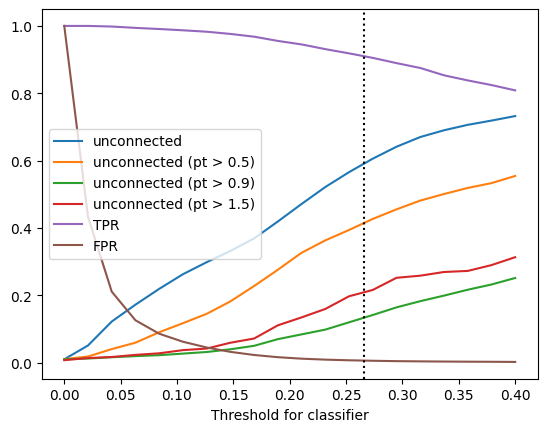

In [94]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots()
ax.plot(thlds, f, label="unconnected")
ax.plot(thlds, f5, label="unconnected (pt > 0.5)")
ax.plot(thlds, f9, label="unconnected (pt > 0.9)")
ax.plot(thlds, f15, label="unconnected (pt > 1.5)")
ax.plot(thlds, items[0], label="TPR")
ax.plot(thlds, items[1], label="FPR")
ax.set_xlabel("Threshold for classifier")
ax.axvline(0.266, color="k", ls=":")
ax.legend()

In [69]:
get_n_unconnected(len(data.x), edge_index[:, w>0.266]) / len(data.x)

0.6319744204636291